# MVA - Homework 1 - Reinforcement Learning (2022/2023)

**Name:** DOULAZMI Waël

## Instructions

* The deadline is **November 10 at 11:59 pm (Paris time).**

* By doing this homework you agree to the late day policy, collaboration and misconduct rules reported on [Piazza](https://piazza.com/class/l4y5ubadwj64mb/post/6).

* **Mysterious or unsupported answers will not receive full credit**. A correct answer, unsupported by calculations, explanation, or algebraic work will receive no credit; an incorrect answer supported by substantially correct calculations and explanations might still receive partial credit.

* Answers should be provided in **English**.

# Colab setup

In [1]:
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
  # install rlberry library
  !pip install git+https://github.com/rlberry-py/rlberry.git@mva2021#egg=rlberry[default] > /dev/null 2>&1

  # install ffmpeg-python for saving videos
  !pip install ffmpeg-python > /dev/null 2>&1

  # packages required to show video
  !pip install pyvirtualdisplay > /dev/null 2>&1
  !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

  print("Libraries installed, please restart the runtime!")


Libraries installed, please restart the runtime!


In [2]:
# Create directory for saving videos
!mkdir videos > /dev/null 2>&1

# Initialize display and import function to show videos
import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video

In [3]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt

# Preparation

In the coding exercises, you will use a *grid-world* MDP, which is represented in Python using the interface provided by the [Gym](https://gym.openai.com/) library. The cells below show how to interact with this MDP and how to visualize it.


In [4]:
from rlberry.envs import GridWorld

def get_env():
  """Creates an instance of a grid-world MDP."""
  env = GridWorld(
      nrows=5,
      ncols=7,
      reward_at = {(0, 6):1.0},
      walls=((0, 4), (1, 4), (2, 4), (3, 4)),
      success_probability=0.9,
      terminal_states=((0, 6),)
  )
  return env

def render_policy(env, policy=None, horizon=50):
  """Visualize a policy in an environment

  Args:
    env: GridWorld
        environment where to run the policy
    policy: np.array
        matrix mapping states to action (Ns).
        If None, runs random policy.
    horizon: int
        maximum number of timesteps in the environment.
  """
  env.enable_rendering()
  state = env.reset()                       # get initial state
  for timestep in range(horizon):
      if policy is None:
        action = env.action_space.sample()  # take random actions
      else:
        action = policy[state]
      next_state, reward, is_terminal, info = env.step(action)
      state = next_state
      if is_terminal:
        break
  # save video and clear buffer
  env.save_video('./videos/gw.mp4', framerate=5)
  env.clear_render_buffer()
  env.disable_rendering()
  # show video
  show_video('./videos/gw.mp4')


[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 
/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [5]:
# Create an environment and visualize it
env = get_env()
render_policy(env)  # visualize random policy

# The reward function and transition probabilities can be accessed through
# the R and P attributes:
print(f"Shape of the reward array = (S, A) = {env.R.shape}")
print(f"Shape of the transition array = (S, A, S) = {env.P.shape}")
print(f"Reward at (s, a) = (1, 0): {env.R[1, 0]}")
print(f"Prob[s\'=2 | s=1, a=0]: {env.P[1, 0, 2]}")
print(f"Number of states and actions: {env.Ns}, {env.Na}")

# The states in the griworld correspond to (row, col) coordinates.
# The environment provides a mapping between (row, col) and the index of
# each state:
print(f"Index of state (1, 0): {env.coord2index[(1, 0)]}")
print(f"Coordinates of state 5: {env.index2coord[5]}")

Shape of the reward array = (S, A) = (31, 4)
Shape of the transition array = (S, A, S) = (31, 4, 31)
Reward at (s, a) = (1, 0): 0.0
Prob[s'=2 | s=1, a=0]: 0.04999999999999999
Number of states and actions: 31, 4
Index of state (1, 0): 6
Coordinates of state 5: (0, 6)


# Part 1 - Dynamic Programming

## Question 1.1

Consider a general MDP with a discount factor of $\gamma < 1$. Assume that the horizon is infinite (so there is no termination). A policy $\pi$ in this MDP
induces a value function $V^\pi$. Suppose an affine transformation is applied to the reward, what is
the new value function? Is the optimal policy preserved?



### **Answer**

We now have a new MDP $M'$ with the same state and action space $(S,A)$, the same transition function $p$ and a new reward function $r'=ar+b, \; (a,b)∈ \mathbb{R}^2$.

Then let $\pi$ be a policy, and $s\in S$  we have: 

$$V_{M'}^\pi (s) = \mathbb{E} [\sum_{t=0}^∞γ^tr'_t | s_0=s, \pi] = a\mathbb{E} [\sum_{t=0}^∞γ^tr_t | s_0=s, \pi]  + b\mathbb{E} [\sum_{t=0}^∞γ^t | s_0=s, \pi]= aV^\pi(s) + \frac{b}{1-γ}$$

Thus $V_{M'}^\pi = aV^\pi + \frac{b}{1-γ} $

If $a> 0$ the optimal policies for $M$ are the optimal policies for $M'$ and conversely.

If $a=0$ an optimal policy for $M$ is an optimal policy for $M'$ as any policy is optimal for $M'$

If $a< 0$ an optimal policy for $M$ is a "worst" policy for $M'$, so it would be optimal only in cases where all the policies lead to the same value.  

## Question 1.2

Consider an infinite-horizon $\gamma$-discounted MDP. We denote by $Q^*$ the $Q$-function of the optimal policy $\pi^*$. Prove that, for any function $Q(s, a)$ (which is **not** necessarily the value function of a policy), the following inequality holds for any state $s$:

$$
V^{\pi_Q}(s) \geq V^*(s) - \frac{2}{1-\gamma}||Q^*-Q||_\infty,
$$

where $||Q^*-Q||_\infty = \max_{s, a} |Q^*(s, a) - Q(s, a)|$ and $\pi_Q(s) \in \arg\max_a Q(s, a)$. Can you use this result to show that any policy $\pi$ such that $\pi(s) \in \arg\max_a Q^*(s, a)$ is optimal?

### **Answer**

We first note the following property, for any state-action pair $(s,a)$:

\begin{align}
\mathcal{T}Q(s,a) &= r(s,a) + \gamma \sum_{s'}p(s'|s,a)\max_{a'}Q(s',a')\\
&= r(s,a) + \gamma \sum_{s'}p(s'|s,a)Q(s',\pi_Q(s'))\\
&= \mathcal{T}^{\pi_Q}Q(s,a)
\end{align}

Hence, $\mathcal{T}Q = \mathcal{T}^{\pi_Q}Q$

Now, we may write, for any state $s$:

\begin{align}
V^*(s) - V^{\pi_Q}(s)&= Q^*(s,\pi^*(s)) - Q^{\pi_Q}(s,\pi_Q(s))\\
 &= \mathcal{T}Q^*(s,\pi^*(s)) - \mathcal{T}^{\pi_Q}Q^{\pi_Q}(s,\pi_Q(s))\\
&= \mathcal{T}Q^*(s,\pi^*(s)) - \mathcal{T}Q(s,\pi^*(s)) + \mathcal{T}Q(s,\pi^*(s)) - \mathcal{T}Q(s,\pi_Q(s)) + \mathcal{T}^{\pi_Q}Q(s,\pi_Q(s)) - \mathcal{T}^{\pi_Q}Q^{\pi_Q}(s,\pi_Q(s))
\end{align}

On one hand using contractivity:
$$
\mathcal{T}Q^*(s,\pi^*(s)) - \mathcal{T}Q(s,\pi^*(s)) \leq \gamma ||Q^* - Q||_∞
$$

Then:

\begin{align}
&\mathcal{T}^{\pi_Q}Q(s,\pi_Q(s)) - \mathcal{T}^{\pi_Q}Q^{\pi_Q}(s,\pi_Q(s)) = \gamma \sum_{s'}p(s'|s,\pi_Q(s))\Big(Q(s', \pi_Q(s')) - Q^{\pi_Q}(s', \pi_Q(s'))\Big)\\
&\leq \gamma||Q-Q^*||_∞  + \gamma \sum_{s'}p(s'|s,\pi_Q(s))\Big(Q^*(s', \pi_Q(s')) - Q^{\pi_Q}(s', \pi_Q(s'))\Big)\\
& \leq \gamma||Q-Q^*||_∞  + \gamma ||V^* - V^{\pi_Q}||_\infty
\end{align}

We used the following fact: $V^*(s') = Q^*(s',\pi^*(s'))\geq Q^*(s', \pi_Q(s'))$

Now we must deal with the remaining term: $\mathcal{T}Q(s,\pi^*(s)) - \mathcal{T}Q(s,\pi_Q(s))$

----
 If we managed to prove the inequality, then if $\pi$ is such that $\pi(s) \in \arg\max_a Q^*(s, a)$ then we will be in the previous case, but having this time $Q=Q^*$ and thus $V^\pi(s)\geq V^*(s) \geq V^\pi(s)$, thus $V^\pi=V^*$, $\pi$ is optimal.




## Question 1.3

In this question, you will implement and compare the policy and value iteration algorithms for a finite MDP. 

Complete the functions `policy_evaluation`, `policy_iteration` and `value_iteration` below.


Compare value iteration and policy iteration. Highlight pros and cons of each method.

### **Answer**

Value iteration: 
- Pros: 
    - No need to invert matrixes, or to solve linear equations
    - Can use a tolerance parameter to control distance to Q*
- Cons:
    - Not an exact algorithm
    - No control on the number of steps required to achieve convergence

Policy iteration:
- Pros:
  - Converge in a finite number of steps to the optimal solution
- Cons:
  - Require linear system solving $(O(|S|^2))$


In [6]:
def policy_evaluation(P, R, policy, gamma=0.9, tol=1e-2):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    value_function = np.zeros(Ns)
    error = 100
    while error > tol:
      new_value_function = np.zeros(Ns)
      for s in range(Ns):
        new_value_function[s] = R[s, policy[s]] + gamma * P[s, policy[s], :] @ value_function
      error = np.max(np.abs(new_value_function - value_function))
      value_function = new_value_function
    # ====================================================
    return value_function

# We also implent it using matrix inversion

def policy_evaluation_matrix(P, R, policy, gamma=0.9):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        policy: np.array
            matrix mapping states to action (Ns)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        value_function: np.array
            The value function of the given policy
    """
    Ns, Na = R.shape
    Rpi = np.zeros(Ns)
    Ppi = np.zeros((Ns, Ns))
    for s in range(Ns):
      Rpi[s] = R[s, policy[s]]
      for s_prime in range(Ns):
        Ppi[s, s_prime] = P[s, policy[s], s_prime]
    V = np.linalg.solve(np.eye(Ns) - gamma * Ppi, Rpi)
    return V

In [7]:
def policy_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        policy: np.array
            the final policy
        V: np.array
            the value function associated to the final policy
    """
    Ns, Na = R.shape
    V = np.zeros(Ns)
    policy = np.ones(Ns, dtype=int)
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    improved_policy = True
    while improved_policy:
      V = policy_evaluation_matrix(P, R, policy)
      new_policy = np.argmax(R + gamma * P @ V, axis=1)
      improved_policy = (new_policy != policy).any()
      policy = new_policy
    # ====================================================
    return policy, V

In [8]:
def value_iteration(P, R, gamma=0.9, tol=1e-3):
    """
    Args:
        P: np.array
            transition matrix (NsxNaxNs)
        R: np.array
            reward matrix (NsxNa)
        gamma: float
            discount factor
        tol: float
            precision of the solution
    Return:
        Q: final Q-function (at iteration n)
        greedy_policy: greedy policy wrt Qn
        Qfs: all Q-functions generated by the algorithm (for visualization)
    """
    Ns, Na = R.shape
    Q = np.zeros((Ns, Na))
    Qfs = [Q]
    # ====================================================
	  # YOUR IMPLEMENTATION HERE 
    #
    error = 100
    while error > tol:
      Q_new = R + gamma * P @ np.max(Q, axis=1)
      error = np.max(np.abs(Q_new - Q))
      Q = Q_new
      Qfs.append(Q)
    # ====================================================
    greedy_policy = np.argmax(Q, axis=1)
    return Q, greedy_policy, Qfs

### Testing your code

[VI]Greedy policy: 



[PI]final policy: 


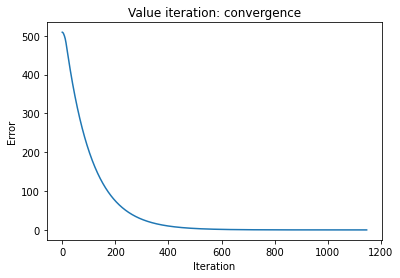

In [9]:
# Parameters
tol = 1e-5
gamma = 0.99

# Environment
env = get_env()

# run value iteration to obtain Q-values
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

# render the policy
print("[VI]Greedy policy: ")
render_policy(env, VI_greedypol)

# compute the value function of the greedy policy using matrix inversion
# ====================================================
# YOUR IMPLEMENTATION HERE 
# compute value function of the greedy policy
#
greedy_V = policy_evaluation_matrix(env.P, env.R, VI_greedypol)
# ====================================================

# show the error between the computed V-functions and the final V-function
# (that should be the optimal one, if correctly implemented)
# as a function of time
final_V = all_qfunctions[-1].max(axis=1)
norms = [ np.linalg.norm(q.max(axis=1) - final_V) for q in all_qfunctions]
plt.plot(norms)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Value iteration: convergence")

#### POLICY ITERATION ####
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)
print("\n[PI]final policy: ")
render_policy(env, PI_policy)

## Uncomment below to check that everything is correct
assert np.allclose(PI_policy, VI_greedypol),\
     "You should check the code, the greedy policy computed by VI is not equal to the solution of PI"
assert np.allclose(PI_V, greedy_V),\
     "Since the policies are equal, even the value function should be"

plt.show()

# Part 2 - Tabular RL

## Question 2.1

The code below collects two datasets of transitions (containing states, actions, rewards and next states) for a discrete MDP.

For each of the datasets:

1. Estimate the transitions and rewards, $\hat{P}$ and $\hat{R}$.
2. Compute the optimal value function and the optimal policy with respect to the estimated MDP (defined by $\hat{P}$ and $\hat{R}$), which we denote by $\hat{\pi}$ and $\hat{V}$.
3. Numerically compare the performance of $\hat{\pi}$ and $\pi^\star$ (the true optimal policy), and the error between $\hat{V}$ and $V^*$ (the true optimal value function).

Which of the two data collection methods do you think is better? Why?

### **Answer**

The risk with the first data collection method, is that if we never manage to reach the goal using a random policy, which is likely to happen because of the wall, then our estimated reward function will be null, and we won't be able to compute any good policy.
While with uniform sampling, each state and action pair is tested, so we have a more global estimation of $R$, and we will have better results.

So the second data collection method is definetely better.

In [10]:
def get_random_policy_dataset(env, n_samples):
  """Get a dataset following a random policy to collect data."""
  states = []
  actions = []
  rewards = []
  next_states = []
  
  state = env.reset()
  for _ in range(n_samples):
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.step(action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    # update state
    state = next_state
    if is_terminal:
      state = env.reset()

  dataset = (states, actions, rewards, next_states)
  return dataset

def get_uniform_dataset(env, n_samples):
  """Get a dataset by uniformly sampling states and actions."""
  states = []
  actions = []
  rewards = []
  next_states = []
  for _ in range(n_samples):
    state = env.observation_space.sample()
    action = env.action_space.sample()
    next_state, reward, is_terminal, info = env.sample(state, action)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)

  dataset = (states, actions, rewards, next_states)
  return dataset


# Collect two different datasets
num_samples = 500
env = get_env()
dataset_1 = get_random_policy_dataset(env, num_samples)
dataset_2 = get_uniform_dataset(env, num_samples)


# Item 3: Estimate the MDP with the two datasets; compare the optimal value
# functions in the true and in the estimated MDPs

# Ground truth
# Parameters
tol = 1e-5
gamma = 0.99
PI_policy, PI_V = policy_iteration(env.P, env.R, gamma=gamma, tol=tol)

# We introduce the N fuctions, and estimate P and R
N_1 = np.zeros((env.Ns, env.Na, env.Ns)) 
R_1 = np.zeros((env.Ns, env.Na))
P_1 = np.zeros((env.Ns, env.Na, env.Ns)) 

for sample in range(num_samples):
  state = dataset_1[0][sample]
  action = dataset_1[1][sample]
  reward = dataset_1[2][sample]
  next_state = dataset_1[3][sample]

  N_1[state, action, next_state] += 1
  R_1[state, action] += reward

# In order to deal with divisions by 0
with np.errstate(divide='ignore', invalid='ignore'):
    R_1 = np.true_divide(R_1, np.sum(N_1, axis=2))
    R_1[R_1 == np.inf] = 0
    R_1 = np.nan_to_num(R_1)
    P_1 = np.true_divide(N_1, np.sum(N_1, axis=2)[:,:,np.newaxis])
    P_1[P_1 == np.inf] = 0
    P_1 = np.nan_to_num(P_1)

hat_policy_1, hat_V_1  = policy_iteration(P_1, R_1, gamma=gamma, tol=tol)

print("\nOptimal policy wrt estimation using random policy dataset")
render_policy(env, hat_policy_1)

print("\nDistance to the optimal value: {}".format(np.max(np.abs(hat_V_1 -PI_V))))

# Same thing with the other dataset

N_2 = np.zeros((env.Ns, env.Na, env.Ns)) 
R_2 = np.zeros((env.Ns, env.Na))
P_2 = np.zeros((env.Ns, env.Na, env.Ns)) 

for sample in range(num_samples):
  state = dataset_2[0][sample]
  action = dataset_2[1][sample]
  reward = dataset_2[2][sample]
  next_state = dataset_2[3][sample]

  N_2[state, action, next_state] += 1
  R_2[state, action] += reward

# In order to deal with divisions by 0
with np.errstate(divide='ignore', invalid='ignore'):
    R_2 = np.true_divide(R_2, np.sum(N_2, axis=2))
    R_2[R_2 == np.inf] = 0
    R_2 = np.nan_to_num(R_2)
    P_2 = np.true_divide(N_2, np.sum(N_2, axis=2)[:,:,np.newaxis])
    P_2[P_2 == np.inf] = 0
    P_2 = np.nan_to_num(P_2)

hat_policy_2, hat_V_2  = policy_iteration(P_2, R_2, gamma=gamma, tol=tol)

print("\nOptimal policy wrt estimation using uniform dataset")
render_policy(env, hat_policy_2)

print("\nDistance to the optimal value: {}".format(np.max(np.abs(hat_V_2-PI_V))))


Optimal policy wrt estimation using random policy dataset



Distance to the optimal value: 8.805868081057003

Optimal policy wrt estimation using uniform dataset



Distance to the optimal value: 1.604379168231035


## Question 2.2

Suppose that $\hat{P}$ and $\hat{R}$ are estimated from a dataset of exactly $N$ i.i.d. samples from **each** state-action pair. This means that, for each $(s,a)$, we have $N$ samples $\{(s_1',r_1, \dots, s_N', r_N\}$, where $s_i' \sim P(\cdot | s,a)$ and $r_i \sim R(s,a)$ for $i=1,\dots,N$, and
$$ \hat{P}(s'|s,a) = \frac{1}{N}\sum_{i=1}^N \mathbb{1}(s_i' = s'), $$
$$ \hat{R}(s,a) = \frac{1}{N}\sum_{i=1}^N r_i.$$
Suppose that $R$ is a distribution with support in $[0,1]$. Let $\hat{V}$ be the optimal value function computed in the empirical MDP (i.e., the one with transitions $\hat{P}$ and rewards $\hat{R}$). For any $\delta\in(0,1)$, derive an upper bound to the error

$$ \| \hat{V} - V^* \|_\infty $$

which holds with probability at least $1-\delta$.

**Note** Your bound should only depend on deterministic quantities like $N$, $\gamma$, $\delta$, $S$, $A$. It should *not* dependent on the actual random samples.

**Hint** The following two inequalities may be helpful.

1. **A (simplified) lemma**. For any state $\bar{s}$,

$$ |\hat{V}(\bar{s}) - V^*(\bar{s})| \leq \frac{1}{1-\gamma}\max_{s,a} \left| R(s,a) - \hat{R}(s,a) + \gamma \sum_{s'}(P(s'|s,a) - \hat{P}(s'|s,a)) V^*(s') \right|$$

2. **Hoeffding's inequality**. Let $X_1, \dots X_N$ be $N$ i.i.d. random variables bounded in the interval $[0,b]$ for some $b>0$. Let $\bar{X} = \frac{1}{N}\sum_{i=1}^N X_i$ be the empirical mean. Then, for any $\epsilon > 0$,

$$ \mathbb{P}(|\bar{X} - \mathbb{E}[\bar{X}]| > \epsilon) \leq 2e^{-\frac{2N\epsilon^2}{b^2}}.$$

### **Answer**

We will use the lemmas without proving them.

For $\delta\in(0,1)$ we may rewrite Hoeffding's inequality as:

\begin{align}
\mathbb{P}\Bigg(\Big|\frac{1}{N}\sum_{i=1}^N X_i - \mathbb{E}[X_1] \Big| > b\sqrt{\frac{\log(\frac{2}{δ})}{2N}}\Bigg) & \leq \delta\\
\mathbb{P}\Bigg(\frac{1}{1-\gamma}\Big|\frac{1}{N}\sum_{i=1}^N X_i - \mathbb{E}[X_1] \Big| > \frac{b}{1-\gamma}\sqrt{\frac{\log(\frac{2}{δ})}{2N}}\Bigg) & \leq \delta\\
\end{align}

Now let's use the first lemma,

\begin{align}
||\hat{V} - V^*||_∞ &\leq \frac{1}{1-\gamma}(||\hat{R} - R||_∞ + \gamma ||\hat{P}- P||_∞ \sum_{s'}V^*(s')) \qquad \text{and} \; V^*(s') \leq \frac{R_{max}}{1-\gamma}\leq \frac{1}{1-\gamma}\\
& \leq \frac{1}{1-\gamma}(||\hat{R} - R||_∞ + \gamma ||\hat{P}- P||_∞\frac{S}{1-\gamma})
\end{align}

Now if we recall that:

$$ 
r(s,a) = \mathbb{E}_{r\sim R(s,a)}[r], \qquad \text{and} \, \mathbb{P}(s'|s,a)=\mathbb{E}_{s,a}[\mathbb{1}(s'_i =s')]
$$

We may apply Hoeffding to both $(r_i)$ and $(\mathbb{1}(s'=s))$ with $b=1$:

\begin{align}
\mathbb{P}\Bigg(\frac{1}{1-\gamma}||\hat{R} - R||_∞ > \frac{1}{1-\gamma}\sqrt{\frac{\log(\frac{2}{δ})}{2N}}\Bigg) & \leq \delta\\
\mathbb{P}\Bigg(\frac{\gamma S}{(1-\gamma)^2}||\hat{P} - P||_∞ > \frac{\gamma S}{(1-\gamma)^2}\sqrt{\frac{\log(\frac{2}{δ})}{2N}}\Bigg) & \leq \delta\\
\end{align}

Combining both, we get to:

$$
\mathbb{P}\Bigg(||\hat{V} - V^*||_∞ \leq \frac{1}{1-\gamma}\bigg(1+\frac{γS}{1-γ}\bigg)\sqrt{\frac{\log(\frac{2}{δ})}{2N}}\Bigg) \geq 1-\delta
$$


## Question 2.3

Suppose once again that we are given a dataset of $N$ samples in the form of tuples $(s_i,a_i,s_i',r_i)$. We know that each tuple contains a valid transition from the true MDP, i.e., $s_i' \sim P(\cdot | s_i, a_i)$ and $r_i \sim R(s_i,a_i)$, while the state-action pairs $(s_i,a_i)$ from which the transition started can be arbitrary.

Suppose we want to apply Q-learning to this MDP. Can you think of a way to leverage this offline data to improve the sample-efficiency of the algorithm? What if we were using SARSA instead?

### **Answer**

We can use this offline data in the initialization of Q, for example by using VI on the approximated MDP. Then Q-learning could iterate on this first estimation of Q and might converge faster.

What can also be done is to directly do offline updates of the Q-function:

\begin{align}
& Q_0 ← \mathrm{VI}(\hat{P}, \hat{R)}, \; N ← 0\\
&\mathrm{for}\; i=1,\dots, N_{samples}:&\\
& \qquad N(s_i,a_i) ← N(s_i,a_i) + 1\\
& \qquad Q(s_i,a_i) ← Q(s_i,a_i) + \frac{1}{N(s_i,a_i)}(r_i + \gamma \max_{a'}(Q(s_i',a'))
\end{align}

If we use SARSA, we want our updates to be on-policy, meaning that we should use $(s,a,r, s', a')$ tuples. But we still can use our offline data to generate an initial value for $Q_0$.

# Part 3 - RL with Function Approximation

## Question 3.1

Given a datset $(s_i, a_i, r_i, s_i')$ of (states, actions, rewards, next states), the Fitted Q-Iteration (FQI) algorithm proceeds as follows:


* We start from a $Q$ function $Q_0 \in \mathcal{F}$, where $\mathcal{F}$ is a function space;
* At every iteration $k$, we compute $Q_{k+1}$ as:

$$
Q_{k+1}\in\arg\min_{f\in\mathcal{F}} \frac{1}{2}\sum_{i=1}^N
\left(
  f(s_i, a_i) - y_i^k
\right)^2 + \lambda \Omega(f)
$$
where $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$, $\Omega(f)$ is a regularization term and $\lambda > 0$ is the regularization coefficient.


Consider FQI with *linear* function approximation. That is, for a given feature map $\phi : S \rightarrow \mathbb{R}^d$, we consider a parametric family of $Q$ functions $Q_\theta(s,a) = \phi(s)^T\theta_a$ for $\theta_a\in\mathbb{R}^d$. Suppose we are applying FQI on a given dataset of $N$ tuples of the form $(s_i, a_i, r_i, s_i')$ and we are at the $k$-th iteration. Let $\theta_k \in\mathbb{R}^{d \times A}$ be our current parameter. Derive the *closed-form* update to find $\theta_{k+1}$, using $\frac{1}{2}\sum_a ||\theta_a||_2^2$ as regularization.

### **Answer**

Using the proposed family function and regularization we aim to minimize the following loss: 

$$
L(θ)= \frac{1}{2}\sum_{i=1}^N
\left(
  \phi(s_i)^Tθ_{a_i} - y_i^k
\right)^2 + \frac{λ}{2}\sum_a ||\theta_a||_2^2 = D(θ) + Ω(θ)
$$

Where $\theta = (\theta_a)_a \in \mathbb{R}^{d×A}$, we may compute the semi-gradient (recall that $y_i^k = r_i + \gamma \max_{a'}Q_k(s_i', a')$ depends on $θ^k$):

$$ Ω(θ) = \frac{λ}{2}||\theta||_2^2, \quad ∇Ω(θ) = λθ $$

$$D(θ) = \frac{1}{2}\sum_{i=1}^N
\left(
  \phi(s_i)^Tθ_{a_i} - y_i^k
\right)^2, \quad ∇D(\theta) = (∇_aD(\theta))_{a\in A} $$

And for $a \in A$:

$$∇_aD(θ) = \sum_{i, \, a_i=a} (\phi(s_i)^Tθ_a - y_i^k)\phi(s_i) $$

Then $θ^{k+1}$ satisfies, $∀a \in A$:

\begin{align*}
λ θ_a +\sum_{i, \, a_i=a} (\phi(s_i)^Tθ_a - y_i^k)\phi(s_i)&=0\\
λθ_a +\sum_{i, \, a_i=a} \phi(s_i)\phi(s_i)^Tθ_j &= \sum_{i, \, a_i=a}y_i^k\phi(s_i)\\
\Big(I_d + \frac{1}{λ} \sum_{i, \, a_i=a} \phi(s_i)\phi(s_i)^T\Big)θ_a &= \frac{1}{λ}\sum_{i, \, a_i=a}y_i^k\phi(s_i)\\
θ_a &= \Big(I_d + \frac{1}{λ} \sum_{i, \, a_i=a} \phi(s_i)\phi(s_i)^T\Big)^{-1}\frac{1}{λ}\sum_{i, \, a_i=a}y_i^k\phi(s_i)
\end{align*}

The matrix is invertible since it is symmetric with strictly positive eigenvalues.

$L$ being stricly convex, it is minimized in $θ^{k+1}$, and the minimum is global.





## Question 3.2

The code below creates a larger gridworld (with more states than the one used in the previous questions), and defines a feature map. Implement linear FQI to this environment (in the function `linear_fqi()` below), and compare the approximated $Q$ function to the optimal $Q$ function computed with value iteration.

Can you improve the feature map in order to reduce the approximation error?

### **Answer**

The problem with the proposed feature map, is that the information encoded is the euclidian distance between two states. I see two ameliorations that can be done :

- Euclidian distance considers that we can move diagonnally, while we actually can't, $L_1$ distance is more representative of the link between states.

- Cheating: we could take the wall into account when computing the similarity between two states.

Indeed, using a similarity that doesn't take into account that two points on opposite sides of the wall are far away, and might lead by construction to solutions where the agent gets stuck on the wall.

So the last feature map we implement tries to consider the wall in the distance computation.

In [11]:
def get_large_gridworld():
  """Creates an instance of a grid-world MDP with more states."""
  walls = [(ii, 10) for ii in range(15) if (ii != 7 and ii != 8)]
  env = GridWorld(
      nrows=15,
      ncols=15,
      reward_at = {(14, 14):1.0},
      walls=tuple(walls),
      success_probability=0.9,
      terminal_states=((14, 14),)
  )
  return env


class GridWorldFeatureMap:
  """Create features for state-action pairs
  
  Args:
    dim: int
      Feature dimension
    sigma: float
      RBF kernel bandwidth
  """
  def __init__(self, env, distance="L2", dim=15, sigma=0.25):
    self.index2coord = env.index2coord
    self.n_states = env.Ns
    self.n_actions = env.Na
    self.dim = dim
    self.sigma = sigma

    n_rows = env.nrows
    n_cols = env.ncols

    row_wall, col_wall = (7.5, 10)
    x_wall = row_wall / n_rows
    y_wall = col_wall / n_cols

    # build similarity matrix
    sim_matrix = np.zeros((self.n_states, self.n_states))
    for ii in range(self.n_states):
        row_ii, col_ii = self.index2coord[ii]
        x_ii = row_ii / n_rows
        y_ii = col_ii / n_cols
        for jj in range(self.n_states):
            row_jj, col_jj = self.index2coord[jj]
            x_jj = row_jj / n_rows
            y_jj = col_jj / n_cols
            if distance=="L2":
              dist = np.sqrt((x_jj - x_ii) ** 2.0 + (y_jj - y_ii) ** 2.0)
            elif distance=="L1":
              dist = np.abs(x_jj - x_ii) + np.abs(y_ii - y_jj)
            elif distance=="Wall":
              wall_y = 10
              if col_ii < 10 and col_jj < 10 or col_ii > 10 and col_jj > 10:
                # The states are ton the same size of the wall
                 dist = np.abs(x_jj - x_ii) + np.abs(y_ii - y_jj)
              else:
                #dist = i --> wall + wall --> j
                dist = np.abs(x_wall - x_ii) + np.abs(x_wall - x_jj) +\
                       np.abs(y_wall - y_ii) + np.abs(y_wall - y_jj)
            sim_matrix[ii, jj] = np.exp(-(dist / sigma) ** 2.0)

    # factorize similarity matrix to obtain features
    uu, ss, vh = np.linalg.svd(sim_matrix, hermitian=True)
    self.feats = vh[:dim, :]

  def map(self, observation):
    feat = self.feats[:, observation].copy()
    return feat

In [12]:
def linear_fqi(env, feat_map, num_iterations, lambd=0.1, gamma=0.95):
  """
  # Linear FQI implementation
  # TO BE COMPLETED
  """

  # get a dataset
  #    dataset = get_uniform_dataset(env, n_samples=...)
  # OR dataset = get_random_policy_dataset(env, n_samples=...)
  # We have Ns states and for each state Na action, to be sure that we sample 
  # each state-action pair at least once, we should take:
  n_samples = 10 * env.Ns * env.Na
  dataset = get_uniform_dataset(env, n_samples=n_samples)
  #dataset = np.array(dataset, dtype=int)

  # Precompute all distances
  features = [feat_map.map(s) for s in range(env.Ns)]

  theta = np.zeros((feat_map.dim, env.Na))

  for it in range(num_iterations):
    # We first compute y
    y = np.zeros(len(dataset[0]))
    for sample in range(n_samples):
      y[sample] = dataset[2][sample] + gamma * np.max(features[dataset[3][sample]] @ theta)
    for a in range(env.Na):
      # We compute each term
      left_sum = np.zeros((feat_map.dim, feat_map.dim))
      right_sum = np.zeros(feat_map.dim)
      for sample in range(n_samples):
          if dataset[1][sample] == a:
            phi = features[dataset[0][sample]].reshape((feat_map.dim, 1))
            left_sum += phi @ phi.T
            right_sum += y[sample] * phi[:,0]
      left_term = np.eye(feat_map.dim) + 1/lambd * left_sum
      theta[:,a] = np.linalg.solve(left_term, 1/lambd * right_sum)   
  
  return theta

**Ground Truth**

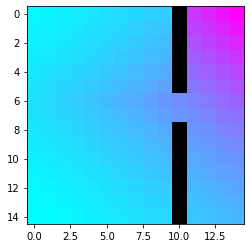

In [13]:
env = get_large_gridworld()

tol = 1e-7
gamma = 0.95
VI_Q, VI_greedypol, all_qfunctions = value_iteration(env.P, env.R, gamma=gamma, tol=tol)

VI_V = VI_Q.max(axis=1)


render_policy(env, VI_greedypol, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(VI_V)    
plt.imshow(img)
plt.show()

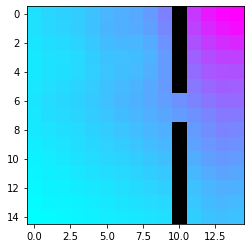

In [15]:
from numpy.random.mtrand import rand
# ----------------------------
# Environment and feature map
# ----------------------------
env = get_large_gridworld()
# you can change the parameters of the feature map, and even try other maps!
feat_map = GridWorldFeatureMap(env, dim=50, sigma=0.25, distance="L2")

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100, gamma=0.95)

# Compute and run greedy policy
Q_fqi_L2 = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi_L2[ss, :] = state_feat @ theta

V_fqi_L2 = Q_fqi_L2.max(axis=1)
policy_fqi_L2 = Q_fqi_L2.argmax(axis=1)
render_policy(env, policy_fqi_L2, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi_L2)    
plt.imshow(img)
plt.show()

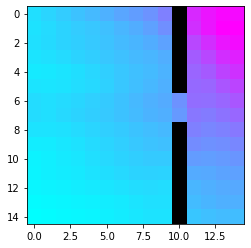

In [16]:
feat_map = GridWorldFeatureMap(env, dim=50, sigma=0.25, distance="L1")

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100, gamma=0.95)

# Compute and run greedy policy
Q_fqi_L1 = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi_L1[ss, :] = state_feat @ theta

V_fqi_L1 = Q_fqi_L1.max(axis=1)
policy_fqi_L1 = Q_fqi_L1.argmax(axis=1)
render_policy(env, policy_fqi_L1, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi_L1)    
plt.imshow(img)
plt.show()

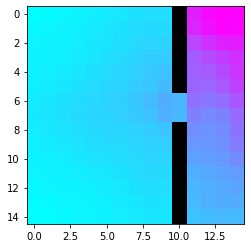

In [18]:
feat_map = GridWorldFeatureMap(env, dim=50, sigma=0.25, distance="Wall")

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100, gamma=0.95)

# Compute and run greedy policy
Q_fqi_Wall = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi_Wall[ss, :] = state_feat @ theta

V_fqi_Wall = Q_fqi_Wall.max(axis=1)
policy_fqi_Wall = Q_fqi_Wall.argmax(axis=1)
render_policy(env, policy_fqi_Wall, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi_Wall)    
plt.imshow(img)
plt.show()

In [19]:
# Distance to Ground Truth:
print("Distances to ground truth : \n")
print("L2 feature map: {}".format(np.max(np.abs(V_fqi_L2, VI_V))))
print("L1 feature map: {}".format(np.max(np.abs(V_fqi_L1, VI_V))))
print("Wall feature map: {}".format(np.max(np.abs(V_fqi_Wall, VI_V))))

Distances to ground truth : 

L2 feature map: 9.49496996870861
L1 feature map: 4.819289298203185
Wall feature map: 5.249091425965124


When using 50 dimensions (high enough dimension to achieve convergence) we see that our proposed features outperform the original one, but in terms of infinite distance between Q values, we have no gain using the cheating trick.

However, looking at the videos, the result we got is more satisfying.

Now let's make one last check in lower dimension :

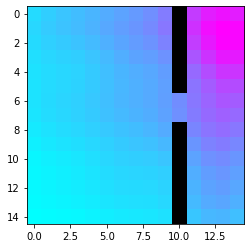

In [20]:
feat_map = GridWorldFeatureMap(env, dim=25, sigma=0.25, distance="L2")

theta = linear_fqi(env, feat_map, num_iterations=100, gamma=0.95)

# Compute and run greedy policy
Q_fqi_L2_25 = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi_L2_25[ss, :] = state_feat @ theta

V_fqi_L2_25 = Q_fqi_L2_25.max(axis=1)
policy_fqi_L2_25 = Q_fqi_L2_25.argmax(axis=1)
render_policy(env, policy_fqi_L2_25, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi_L2_25)    
plt.imshow(img)
plt.show()

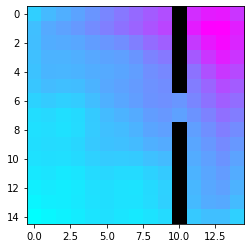

In [21]:
feat_map = GridWorldFeatureMap(env, dim=25, sigma=0.25, distance="L1")

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100, gamma=0.95)

# Compute and run greedy policy
Q_fqi_L1_25 = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi_L1_25[ss, :] = state_feat @ theta

V_fqi_L1_25 = Q_fqi_L1_25.max(axis=1)
policy_fqi_L1_25 = Q_fqi_L1_25.argmax(axis=1)
render_policy(env, policy_fqi_L1_25, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi_L1_25)    
plt.imshow(img)
plt.show()

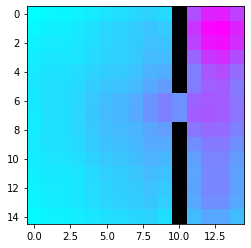

In [30]:
feat_map = GridWorldFeatureMap(env, dim=25, sigma=0.25, distance="Wall")

# -------
# Run FQI
# -------
theta = linear_fqi(env, feat_map, num_iterations=100, gamma=0.95)

# Compute and run greedy policy
Q_fqi_Wall_25 = np.zeros((env.Ns, env.Na))
for ss in range(env.Ns):
  state_feat = feat_map.map(ss)
  Q_fqi_Wall_25[ss, :] = state_feat @ theta

V_fqi_Wall_25 = Q_fqi_Wall_25.max(axis=1)
policy_fqi_Wall_25 = Q_fqi_Wall_25.argmax(axis=1)
render_policy(env, policy_fqi_Wall_25, horizon=100)

# Visualize the approximate value function in the gridworld.
img = env.get_layout_img(V_fqi_Wall_25)    
plt.imshow(img)
plt.show()

In [31]:
# Distance to Ground Truth:
print("Distances to ground truth : \n")
print("L2 feature map: {}".format(np.max(np.abs(V_fqi_L2_25, VI_V))))
print("L1 feature map: {}".format(np.max(np.abs(V_fqi_L1_25, VI_V))))
print("Wall feature map: {}".format(np.max(np.abs(V_fqi_Wall_25, VI_V))))

Distances to ground truth : 

L2 feature map: 3.1999861623900654
L1 feature map: 2.888178517204445
Wall feature map: 2.583407255955672


When working with lower dimension, our wall-trick seems to do the job, and the agents gets to the reward.